In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
import sys
import os

# import the dataset and gain insight about major descriptive statistics
warnings.filterwarnings('ignore')
dataset = pd.read_csv("heloc_dataset_v1.csv", header = [0])
insight = dataset.describe()
insight


,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,MaxDelq2PublicRecLast12M,...,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
count,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,...,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000
mean,67.425758,184.205373,8.543455,73.843293,19.428052,0.042738,-0.142843,86.661536,6.762406,4.928291,...,32.166460,-0.325366,0.868152,0.812602,31.629888,39.158906,3.185008,0.976097,0.018071,62.079166
std,21.121621,109.683816,13.301745,38.782803,13.004327,2.513910,2.367397,25.999584,20.501250,3.756275,...,20.128634,6.067556,3.179304,3.143698,30.060140,42.101601,4.413173,4.060995,3.358135,27.711565
min,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,...,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000
25%,63.000000,118.000000,3.000000,52.000000,12.000000,0.000000,0.000000,87.000000,-7.000000,4.000000,...,20.000000,-7.000000,0.000000,0.000000,5.000000,-8.000000,2.000000,1.000000,0.000000,47.000000
50%,71.000000,178.000000,5.000000,74.000000,19.000000,0.000000,0.000000,96.000000,-7.000000,6.000000,...,31.000000,0.000000,1.000000,1.000000,25.000000,47.000000,3.000000,2.000000,0.000000,67.000000
75%,79.000000,249.500000,11.000000,95.000000,27.000000,1.000000,0.000000,100.000000,14.000000,7.000000,...,44.000000,1.000000,2.000000,2.000000,54.000000,79.000000,5.000000,3.000000,1.000000,82.000000
max,94.000000,803.000000,383.000000,383.000000,79.000000,19.000000,19.000000,100.000000,83.000000,9.000000,...,100.000000,24.000000,66.000000,66.000000,232.000000,471.000000,32.000000,23.000000,18.000000,100.000000


In [3]:
# count the number of outliers in each attribute and calculate the average number of outliers in dataset
total = 0
print("Number of outliers: \n")
for out_col in dataset.columns[1:]:
    Q1 = insight.loc["25%", out_col]
    Q3 = insight.loc["75%", out_col]
    IQR = Q3-Q1
    temp_col = dataset.loc[:,out_col]
    outli = (len(temp_col.loc[temp_col> Q3+1.5*IQR]) + len(temp_col.loc[temp_col< Q1-1.5*IQR]))
    total += outli
    print(out_col, outli)
    
print("\nAverage number of outlier: ", total/23)


Number of outliers: 

ExternalRiskEstimate 603
MSinceOldestTradeOpen 147
MSinceMostRecentTradeOpen 758
AverageMInFile 231
NumSatisfactoryTrades 184
NumTrades60Ever2DerogPubRec 1163
NumTrades90Ever2DerogPubRec 2820
PercentTradesNeverDelq 1081
MSinceMostRecentDelq 779
MaxDelq2PublicRecLast12M 588
MaxDelqEver 588
NumTotalTrades 226
NumTradesOpeninLast12M 706
PercentInstallTrades 147
MSinceMostRecentInqexcl7days 418
NumInqLast6M 987
NumInqLast6Mexcl7days 957
NetFractionRevolvingBurden 5
NetFractionInstallBurden 1
NumRevolvingTradesWBalance 1294
NumInstallTradesWBalance 1679
NumBank2NatlTradesWHighUtilization 2415
PercentTradesWBalance 606

Average number of outlier:  799.2608695652174


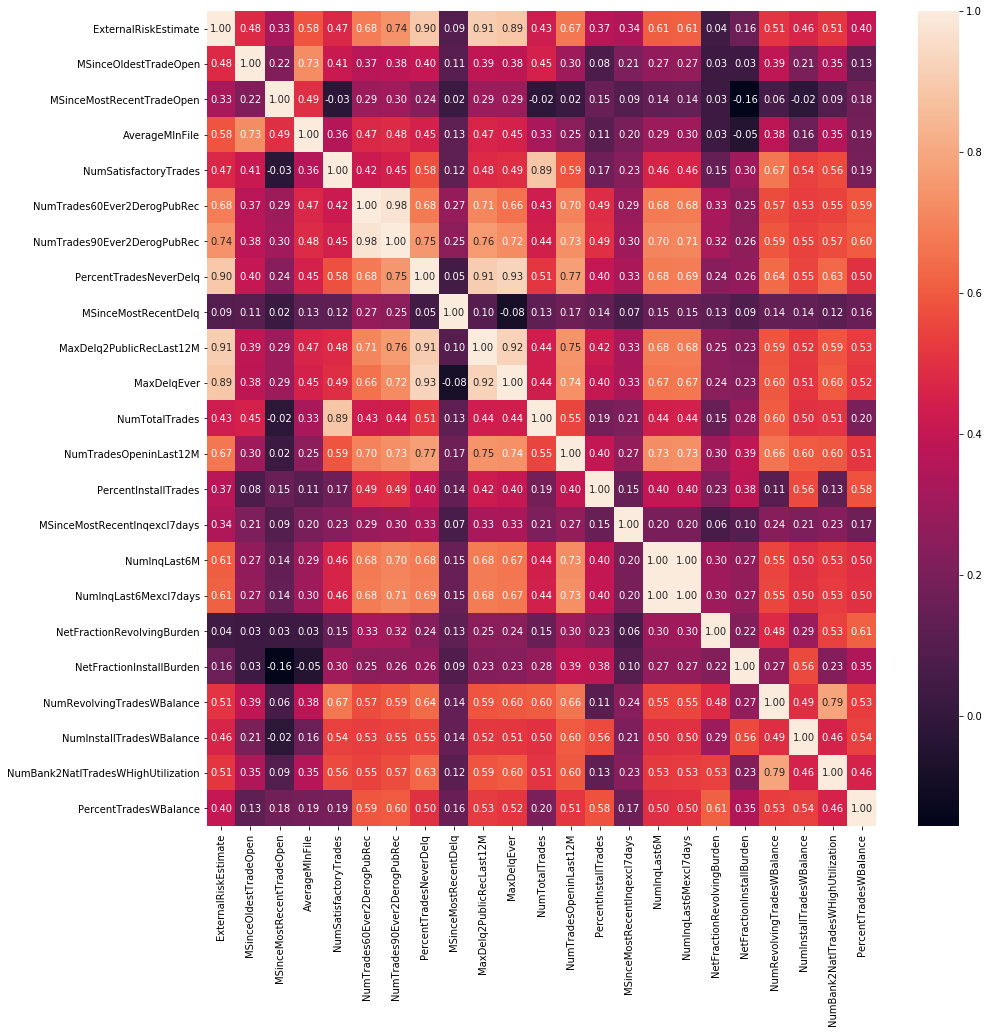

In [4]:
# show the heatmap of the correlation of attributes in dataset
fig,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(dataset.corr(), annot=True, fmt= '.2f') # Correlation Demo
plt.show()

In [5]:
# factorize the output varibale and drop rows with all attributes -9
from sklearn.model_selection import train_test_split

df = dataset.copy()

df['RiskPerformance'] = pd.factorize(df['RiskPerformance'])[0]
empty_zero_count = 0
empty_one_count = 0

for index, row in df.iterrows():
    if sum(row[1:]) == -9 * 23: # Drop row if all columus have value -9
        df.drop([index], inplace = True) # Drop empty rows
        if row[0] == 0:
            empty_zero_count+=1 # record the number of target Bad(0) and Good(1) dropped
        else:
            empty_one_count+=1
print("Performance of Dropped Empty Rows")            
print("Bad:", empty_zero_count, "rows")
print("Good:", empty_one_count, "rows")


Performance of Dropped Empty Rows
Bad: 323 rows
Good: 265 rows


In [6]:
# gain insight about the number of occurance of each special value in each attribute
col_names = list(df)
spec_values = pd.DataFrame(columns=['-7', '-8', '-9', '0', '100'])

for col_name in col_names: # gain insight about the number of special values -7, -8, -9
    minus_7_count = 0
    minus_8_count = 0
    minus_9_count = 0
    zero_count = 0
    hundred_count = 0
    for i in df.loc[:][col_name]:
        if i == -7:
            minus_7_count+=1
        elif i == -8:
            minus_8_count+=1
        elif i == -9:
            minus_9_count+=1
        elif i == 0:
            zero_count+=1
        elif i == 100:
            hundred_count+=1
    spec_values.loc[col_name,:] = [minus_7_count, minus_8_count, minus_9_count, zero_count, hundred_count]

print(spec_values)
df.describe()
            


                                        -7      -8    -9       0     100
RiskPerformance                        0.0     0.0   0.0  5136.0     0.0
ExternalRiskEstimate                   0.0     0.0  10.0     0.0     0.0
MSinceOldestTradeOpen                  0.0   239.0   0.0     0.0    17.0
MSinceMostRecentTradeOpen              0.0     0.0   0.0   105.0     3.0
AverageMInFile                         0.0     0.0   0.0     0.0    79.0
NumSatisfactoryTrades                  0.0     0.0   0.0     4.0     0.0
NumTrades60Ever2DerogPubRec            0.0     0.0   0.0  6802.0     0.0
NumTrades90Ever2DerogPubRec            0.0     0.0   0.0  7639.0     0.0
PercentTradesNeverDelq                 0.0     0.0   0.0     6.0  4607.0
MSinceMostRecentDelq                4664.0   176.0   0.0   102.0     0.0
MaxDelq2PublicRecLast12M               0.0     0.0   0.0   336.0     0.0
MaxDelqEver                            0.0     0.0   0.0     0.0     0.0
NumTotalTrades                         0.0     0.0 

,RiskPerformance,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,...,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
count,9871.000000,9871.000000,9871.000000,9871.000000,9871.000000,9871.000000,9871.000000,9871.000000,9871.000000,9871.000000,...,9871.000000,9871.000000,9871.000000,9871.000000,9871.000000,9871.000000,9871.000000,9871.000000,9871.000000,9871.000000
mean,0.479688,71.978320,195.714315,9.588492,78.778138,21.121467,0.581400,0.384763,92.359943,7.701347,...,34.618681,0.191369,1.455982,1.397123,34.050147,42.027657,3.910850,1.570358,0.555263,66.313241
std,0.499613,10.198244,101.936102,12.963398,34.066063,11.321396,1.238783,0.993223,11.772876,20.728177,...,17.953432,5.853077,2.136161,2.096102,29.210292,41.614214,3.356217,3.345442,2.610624,22.243329
min,0.000000,-9.000000,-8.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,-8.000000,...,0.000000,-8.000000,0.000000,0.000000,-8.000000,-8.000000,-8.000000,-8.000000,-8.000000,-8.000000
25%,0.000000,64.000000,131.000000,3.000000,57.000000,13.000000,0.000000,0.000000,89.000000,-7.000000,...,21.000000,0.000000,0.000000,0.000000,8.000000,-8.000000,2.000000,1.000000,0.000000,50.000000
50%,0.000000,72.000000,183.000000,6.000000,76.000000,20.000000,0.000000,0.000000,97.000000,0.000000,...,33.000000,0.000000,1.000000,1.000000,28.000000,52.000000,3.000000,2.000000,1.000000,67.000000
75%,1.000000,80.000000,255.000000,12.000000,97.000000,28.000000,1.000000,0.000000,100.000000,15.000000,...,45.000000,1.000000,2.000000,2.000000,56.000000,80.000000,5.000000,3.000000,1.000000,83.000000
max,1.000000,94.000000,803.000000,383.000000,383.000000,79.000000,19.000000,19.000000,100.000000,83.000000,...,100.000000,24.000000,66.000000,66.000000,232.000000,471.000000,32.000000,23.000000,18.000000,100.000000


In [8]:
# handle the special values by dropping -9, -7 replace by median, -8 replaced by mean
df1 = df.copy()

df1 = df1.replace([-9], np.NaN)
df1 = df1.dropna()

y = df1.iloc[:, 0]
X = df1.drop(['RiskPerformance'], axis=1)

np.random.seed(1)
train_X, test_X, train_y, test_y  = train_test_split(X, y)

median1 = train_X.loc[:,'MSinceMostRecentDelq'].median()
median2 = train_X.loc[:,'MSinceMostRecentInqexcl7days'].median()

train_X.loc[:,'MSinceMostRecentDelq'].replace([-7], median1, inplace = True)
test_X.loc[:,'MSinceMostRecentDelq'].replace([-7], median1, inplace = True)

train_X.loc[:,'MSinceMostRecentInqexcl7days'].replace([-7], median2, inplace = True)
test_X.loc[:,'MSinceMostRecentInqexcl7days'].replace([-7], median2, inplace = True)

mean_map = {}
for i in [1,8,14,17,18,19,20,21,22]:
    mean = train_X.iloc[:,i].mean()
    mean_map[i] = mean
    train_X.iloc[:,i].replace([-8], mean, inplace = True)
    test_X.iloc[:,i].replace([-8], mean, inplace = True)

# convert all categorical variables to dummy variables   
train_cate = train_X.loc[:, ['MaxDelq2PublicRecLast12M', 'MaxDelqEver']]
train_X = train_X.drop(['MaxDelq2PublicRecLast12M', 'MaxDelqEver'], axis=1)

temp0 = pd.get_dummies(pd.Series(train_cate.iloc[:, 0]), drop_first=False)
temp1 = pd.get_dummies(pd.Series(train_cate.iloc[:, 1]), drop_first=False)
train_X = pd.concat([train_X, temp0, temp1], axis = 1)
train_X.reset_index(drop=True, inplace = True)

test_cate = test_X.loc[:, ['MaxDelq2PublicRecLast12M', 'MaxDelqEver']]
test_X = test_X.drop(['MaxDelq2PublicRecLast12M', 'MaxDelqEver'], axis=1)

temp2 = pd.get_dummies(pd.Series(test_cate.iloc[:, 0]), drop_first=False)
temp3 = pd.get_dummies(pd.Series(test_cate.iloc[:, 1]), drop_first=False)
test_X = pd.concat([test_X, temp2, temp3], axis = 1)
test_X.reset_index(drop=True, inplace = True)


# Show the test result of different combinations of using mean or median to handle -7, -8 special values

# -7mean -8mean
# Classifier	Test Score	CV Score	Time
# 0	SVM	0.720600	0.737120	3.118087
# 1	LR	0.718978	0.738201	0.065442
# 2	KNN	0.688564	0.712914	0.045172
# 3	NB	0.555150	0.608384	0.003142
# 4	Tree	0.708435	0.712373	0.014754
# 5	RF	0.709651	0.723191	0.343105
# 6	Boosting	0.717762	0.739419	1.045942

# -7median -8median
# 	Classifier	Test Score	CV Score	Time
# 0	SVM	0.719789	0.735767	2.757119
# 1	LR	0.717762	0.738472	0.061278
# 2	KNN	0.688564	0.713185	0.044816
# 3	NB	0.554339	0.608249	0.003127
# 4	Tree	0.702758	0.714537	0.014649
# 5	RF	0.718167	0.726031	0.342864
# 6	Boosting	0.712490	0.735632	0.966277

# -7mean -8median 
# 	Classifier	Test Score	CV Score	Time
# 0	SVM	0.716545	0.735362	3.499811
# 1	LR	0.718573	0.738201	0.058558
# 2	KNN	0.687753	0.713996	0.046782
# 3	NB	0.555150	0.608519	0.003073
# 4	Tree	0.702758	0.714537	0.014448
# 5	RF	0.706002	0.723462	0.489321
# 6	Boosting	0.713301	0.735903	0.970788

# -7median -8mean 
# Classifier	Test Score	CV Score	Time
# 0	SVM	0.721006	0.736849	5.195849
# 1	LR	0.718573	0.737525	0.058889
# 2	KNN	0.688970	0.712373	0.045222
# 3	NB	0.554339	0.608790	0.003265
# 4	Tree	0.708435	0.712373	0.014646
# 5	RF	0.714923	0.734145	0.341349
# 6	Boosting	0.719384	0.739554	0.973445

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings('ignore')
np.random.seed(1)

# Using different scaler and models to compare the performancc

scaler = StandardScaler().fit(train_X)
# scaler = MinMaxScaler().fit(train_X)
# scaler = MaxAbsScaler().fit(train_X)
# scaler = RobustScaler().fit(train_X)
# scaler = Normalizer().fit(train_X)
train_X = scaler.transform(train_X)
test_X = scaler.transform(test_X)

def evaluate_model(model, model_name, params):
    grid_search = GridSearchCV(model, params, cv=3)
    model_fit = grid_search.fit(train_X, train_y)
    best_model = model_fit.best_estimator_
    
    res = {}
    res["Classifier"] = model_name
    res["Test Score"] = best_model.score(test_X, test_y)
    res["CV Score"] = model_fit.best_score_
    res["Time"] = model_fit.refit_time_
    return res

# The test result of the attempt of using different scalers 

# StandardScaler
# Classifier	Test Score	CV Score	Time
# 0	SVM	0.721006	0.736849	5.243983
# 1	LR	0.718573	0.737525	0.054183
# 2	KNN	0.688970	0.712373	0.046580
# 3	NB	0.554339	0.608790	0.003184
# 4	Tree	0.708435	0.712373	0.014587
# 5	RF	0.714923	0.734145	0.343328
# 6	Boosting	0.719384	0.739554	0.996337

# MinMaxScaler
# 	Classifier	Test Score	CV Score	Time
# 0	SVM	0.718573	0.737390	1.921749
# 1	LR	0.722222	0.736444	0.842071
# 2	KNN	0.699919	0.713455	0.011117
# 3	NB	0.579075	0.626369	0.003009
# 4	Tree	0.708435	0.712373	0.014686
# 5	RF	0.712895	0.733604	0.342364
# 6	Boosting	0.719384	0.739554	0.970570

# MaxAbsScaler
# Classifier	Test Score	CV Score	Time
# 0	SVM	0.720195	0.736714	2.032072
# 1	LR	0.722628	0.737525	0.051510
# 2	KNN	0.699108	0.713049	0.014121
# 3	NB	0.579075	0.626369	0.003140
# 4	Tree	0.708435	0.712373	0.014533
# 5	RF	0.711679	0.733604	0.343618
# 6	Boosting	0.719384	0.739554	0.972888

# RobustScaler 
# Classifier	Test Score	CV Score	Time
# 0	SVM	0.720612	0.738878	3.442161
# 1	LR	0.719384	0.738742	0.048652
# 2	KNN	0.693025	0.714672	0.012220
# 3	NB	0.600162	0.638134	0.003086
# 4	Tree	0.708435	0.712373	0.014671
# 5	RF	0.712490	0.733198	0.339745
# 6	Boosting	0.719384	0.739554	0.970787

# Normalizer
# Classifier	Test Score	CV Score	Time
# 0	SVM	0.683698	0.696416	2.102703
# 1	LR	0.696269	0.706018	0.796955
# 2	KNN	0.662612	0.682759	0.008500
# 3	NB	0.627332	0.646653	0.003046
# 4	Tree	0.682482	0.698986	0.042574
# 5	RF	0.710462	0.722786	0.616634
# 6	Boosting	0.721411	0.734145	2.613329

In [10]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

## models and parameters details are from Homework5 part3
    
# The function `init_classifiers` returns a list of classifiers to be trained on the datasets
def init_classifiers():
    return([(SVC(), model_names[0], param_grid_svc), 
            (LogisticRegression(), model_names[1], param_grid_logistic),
            (KNeighborsClassifier(), model_names[2], param_grid_knn),
            (GaussianNB(), model_names[3], param_grid_nb),
            (DecisionTreeClassifier(), model_names[4], param_grid_tree),
            (RandomForestClassifier(), model_names[6], param_grid_rf),
            (AdaBoostClassifier(), model_names[7], param_grid_boost)
           ])

# 'model_names' contains the names  that we will use for the above classifiers
model_names = ['SVM','LR','KNN','NB','Tree','QDA','RF','Boosting']

# the training parameters of each model
param_grid_svc = [{'C':[0.1, 1],'kernel':['rbf','linear'], 'max_iter':[-1],'random_state':[1]}]
param_grid_logistic = [{'C':[0.1,1], 'penalty':['l1','l2'],'random_state':[1]}]
param_grid_knn = [{},{'n_neighbors':[1,2,3,4,5,6,7,8,9,10]}]
param_grid_nb = [{}]
param_grid_tree = [{'random_state':[1]},{'criterion':['gini'], 'max_depth':[2,3], 'min_samples_split':[3,5],'random_state':[1]}]
param_grid_rf = [{'random_state':[1]},{'n_estimators':[10,30],'max_features':[0.2, 0.3], 'bootstrap':[True],'random_state':[1]}]

param_grid_boost = [{'random_state':[1]},{'n_estimators': [10, 20, 40, 50, 100, 140, 150, 200] ,'learning_rate':[0.1, 0.5, 1],'random_state':[1]}]


In [11]:
# The fianl evalution result of using standard scaler to train 7 different models
classifiers = init_classifiers()
df_ = []
for classifier in classifiers:
            df_.append(evaluate_model(classifier[0], classifier[1], classifier[2]))
df_model_comparison = pd.DataFrame(df_, columns = ['Classifier', 'Test Score', 'CV Score', 'Time'])

df_model_comparison

,Classifier,Test Score,CV Score,Time
0,SVM,0.721006,0.736849,5.368133
1,LR,0.718573,0.737525,0.062319
2,KNN,0.688970,0.712373,0.047478
3,NB,0.554339,0.608790,0.003166
4,Tree,0.708435,0.712373,0.021493
5,RF,0.714923,0.734145,0.349191
6,Boosting,0.719384,0.739554,1.004854


In [12]:
# Get the final best model for later computations
final_para = [{'C':[0.1, 1],'kernel':['linear'], 'max_iter':[-1],'random_state':[1]}]

final_grid_search = GridSearchCV(SVC(), final_para, cv=3)
final_model_fit = final_grid_search.fit(train_X, train_y)
final_best_model = final_model_fit.best_estimator_
print("Test Score", final_best_model.score(test_X, test_y))
final_best_model.coef_

Test Score 0.7210056772100568


array([[ 0.40380678,  0.06558879, -0.05975947,  0.19811612,  0.36001992,
         0.03029302, -0.06981715,  0.13687629,  0.10764548, -0.00215217,
        -0.04987075, -0.1359367 ,  0.15456517, -0.57501092,  0.46043099,
        -0.25943851, -0.02801292, -0.18901091,  0.01033628, -0.14947956,
         0.07199696, -0.01988743,  0.03108994, -0.01585834,  0.00466433,
        -0.0964571 , -0.09404366, -0.00291882,  0.10838899, -0.0058497 ,
        -0.0350623 ,  0.00592287,  0.0026329 , -0.03772001, -0.02678433,
         0.06091244,  0.04800729]])

In [13]:
# Gain insight of the prediction result, show the descriptive statistics of two sets: 'Good' and 'Bad' results
bad = []
good = []
for i in range(test_X.shape[0]):
    if final_best_model.predict(pd.DataFrame(test_X).iloc[i,:].values.reshape(1, -1))[0] == 0:
        bad.append(i)
    else:
        good.append(i)

In [14]:
display(X.iloc[bad, :].describe())
display(X.iloc[good, :].describe())

,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,MaxDelq2PublicRecLast12M,...,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
count,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.00000,1260.00000,...,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000
mean,71.237302,191.000000,9.127778,76.873810,21.004762,0.642063,0.450794,92.226984,7.52381,5.67619,...,33.778571,-1.204762,1.557143,1.496825,36.546032,40.700000,4.129365,1.532540,0.692857,67.923016
std,9.596053,99.440125,10.587599,33.595394,11.822354,1.313331,1.050719,11.797372,20.27363,1.75955,...,17.640241,5.042092,2.159797,2.110714,29.637207,41.640454,3.671792,3.358352,2.676960,22.182676
min,43.000000,-8.000000,0.000000,4.000000,1.000000,0.000000,0.000000,25.000000,-8.00000,0.00000,...,0.000000,-8.000000,0.000000,0.000000,-8.000000,-8.000000,-8.000000,-8.000000,-8.000000,-8.000000
25%,64.000000,126.750000,3.000000,55.000000,13.000000,0.000000,0.000000,89.000000,-7.00000,5.00000,...,21.000000,-7.000000,0.000000,0.000000,10.000000,-8.000000,2.000000,1.000000,0.000000,50.000000
50%,70.000000,183.000000,6.000000,74.000000,19.000000,0.000000,0.000000,97.000000,1.00000,6.00000,...,32.000000,0.000000,1.000000,1.000000,32.000000,50.000000,4.000000,2.000000,1.000000,69.000000
75%,79.000000,251.250000,12.000000,96.000000,28.000000,1.000000,1.000000,100.000000,15.00000,7.00000,...,44.000000,0.000000,2.000000,2.000000,59.000000,79.000000,6.000000,3.000000,2.000000,86.000000
max,93.000000,545.000000,145.000000,258.000000,79.000000,13.000000,12.000000,100.000000,81.00000,7.00000,...,100.000000,23.000000,29.000000,29.000000,120.000000,152.000000,32.000000,23.000000,18.000000,100.000000


,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,MaxDelq2PublicRecLast12M,...,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
count,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,...,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000
mean,71.441957,190.289386,9.085406,77.218905,21.462687,0.611111,0.414594,92.276119,8.106136,5.689884,...,33.686567,-1.398839,1.480100,1.413765,35.717247,43.197347,4.179104,1.609453,0.639303,67.296849
std,9.614280,101.340624,10.680428,33.047334,11.741469,1.276864,1.066543,11.948057,21.546060,1.673820,...,17.712399,5.332524,2.007253,1.946703,29.381997,41.268165,3.470960,3.450546,2.691634,22.511403
min,49.000000,-8.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,-8.000000,0.000000,...,0.000000,-8.000000,0.000000,0.000000,-8.000000,-8.000000,-8.000000,-8.000000,-8.000000,-8.000000
25%,64.000000,126.000000,3.000000,55.000000,13.000000,0.000000,0.000000,89.000000,-7.000000,5.000000,...,21.000000,-7.000000,0.000000,0.000000,8.250000,-8.000000,2.000000,1.000000,0.000000,50.000000
50%,70.000000,179.000000,6.000000,74.000000,20.000000,0.000000,0.000000,97.000000,1.000000,6.000000,...,31.000000,0.000000,1.000000,1.000000,31.000000,53.000000,4.000000,2.000000,1.000000,69.000000
75%,79.000000,251.000000,12.000000,96.000000,28.000000,1.000000,0.000000,100.000000,15.000000,7.000000,...,44.000000,0.000000,2.000000,2.000000,58.000000,80.000000,6.000000,3.000000,2.000000,83.000000
max,94.000000,789.000000,104.000000,213.000000,70.000000,17.000000,16.000000,100.000000,82.000000,7.000000,...,100.000000,23.000000,13.000000,13.000000,120.000000,190.000000,24.000000,14.000000,11.000000,100.000000


In [16]:
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual

# using ipywidges sliders to develop a interactive interface for users to predict the applications

style = {'description_width': '200px'}
layout = {'width': '600px'}
a = widgets.IntSlider(min=-9,max=100, description='ExternalRiskEstimate', layout = layout, style=style)
b = widgets.IntSlider(min=-9,max=1000, description='MSinceOldestTradeOpen', layout = layout, style=style)
c = widgets.IntSlider(min=-9,max=100, description='MSinceMostRecentTradeOpen', layout = layout, style=style)
d = widgets.IntSlider(min=-9,max=1000, description='AverageMInFile', layout = layout, style=style)
e = widgets.IntSlider(min=-9,max=100, description='NumSatisfactoryTrades', layout = layout, style=style)
f = widgets.IntSlider(min=-9,max=100, description='NumTrades60Ever2DerogPubRec', layout = layout, style=style)
g = widgets.IntSlider(min=-9,max=100, description='NumTrades90Ever2DerogPubRec', layout = layout, style=style)
h = widgets.IntSlider(min=-9,max=100, description='PercentTradesNeverDelq', layout = layout, style=style)
i = widgets.IntSlider(min=-9,max=100, description='MSinceMostRecentDelq', layout = layout, style=style)

j = widgets.IntSlider(min=0,max=9, description='MaxDelq2PublicRecLast12M', layout = layout, style=style)
k = widgets.IntSlider(min=2,max=8, description='MaxDelqEver', layout = layout, style=style)

l = widgets.IntSlider(min=-9,max=100, description='NumTotalTrades', layout = layout, style=style)
m = widgets.IntSlider(min=-9,max=100, description='NumTradesOpeninLast12M', layout = layout, style=style)
n = widgets.IntSlider(min=-9,max=100, description='PercentInstallTrades', layout = layout, style=style)
o = widgets.IntSlider(min=-9,max=100, description='MSinceMostRecentInqexcl7days', layout = layout, style=style)
p = widgets.IntSlider(min=-9,max=100, description='NumInqLast6M', layout = layout, style=style)
q = widgets.IntSlider(min=-9,max=100, description='NumInqLast6Mexcl7days', layout = layout, style=style)
r = widgets.IntSlider(min=-9,max=100, description='NetFractionRevolvingBurden', layout = layout, style=style)
s = widgets.IntSlider(min=-9,max=100, description='NetFractionInstallBurden', layout = layout, style=style)
t = widgets.IntSlider(min=-9,max=100, description='NumRevolvingTradesWBalance', layout = layout, style=style)
u = widgets.IntSlider(min=-9,max=100, description='NumInstallTradesWBalance', layout = layout, style=style)
v = widgets.IntSlider(min=-9,max=100, description='NumBank2NatlTradesWHighUtilization', layout = layout, style=style)
w = widgets.IntSlider(min=-9,max=100, description='PercentTradesWBalance', layout = layout, style=style)

display(a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w)

IntSlider(value=0, description='ExternalRiskEstimate', layout=Layout(width='600px'), min=-9, style=SliderStyle(description_width='200px'))

IntSlider(value=0, description='MSinceOldestTradeOpen', layout=Layout(width='600px'), max=1000, min=-9, style=SliderStyle(description_width='200px'))

IntSlider(value=0, description='MSinceMostRecentTradeOpen', layout=Layout(width='600px'), min=-9, style=SliderStyle(description_width='200px'))

IntSlider(value=0, description='AverageMInFile', layout=Layout(width='600px'), max=1000, min=-9, style=SliderStyle(description_width='200px'))

IntSlider(value=0, description='NumSatisfactoryTrades', layout=Layout(width='600px'), min=-9, style=SliderStyle(description_width='200px'))

IntSlider(value=0, description='NumTrades60Ever2DerogPubRec', layout=Layout(width='600px'), min=-9, style=SliderStyle(description_width='200px'))

IntSlider(value=0, description='NumTrades90Ever2DerogPubRec', layout=Layout(width='600px'), min=-9, style=SliderStyle(description_width='200px'))

IntSlider(value=0, description='PercentTradesNeverDelq', layout=Layout(width='600px'), min=-9, style=SliderStyle(description_width='200px'))

IntSlider(value=0, description='MSinceMostRecentDelq', layout=Layout(width='600px'), min=-9, style=SliderStyle(description_width='200px'))

IntSlider(value=0, description='MaxDelq2PublicRecLast12M', layout=Layout(width='600px'), max=9, style=SliderStyle(description_width='200px'))

IntSlider(value=2, description='MaxDelqEver', layout=Layout(width='600px'), max=8, min=2, style=SliderStyle(description_width='200px'))

IntSlider(value=0, description='NumTotalTrades', layout=Layout(width='600px'), min=-9, style=SliderStyle(description_width='200px'))

IntSlider(value=0, description='NumTradesOpeninLast12M', layout=Layout(width='600px'), min=-9, style=SliderStyle(description_width='200px'))

IntSlider(value=0, description='PercentInstallTrades', layout=Layout(width='600px'), min=-9, style=SliderStyle(description_width='200px'))

IntSlider(value=0, description='MSinceMostRecentInqexcl7days', layout=Layout(width='600px'), min=-9, style=SliderStyle(description_width='200px'))

IntSlider(value=0, description='NumInqLast6M', layout=Layout(width='600px'), min=-9, style=SliderStyle(description_width='200px'))

IntSlider(value=0, description='NumInqLast6Mexcl7days', layout=Layout(width='600px'), min=-9, style=SliderStyle(description_width='200px'))

IntSlider(value=0, description='NetFractionRevolvingBurden', layout=Layout(width='600px'), min=-9, style=SliderStyle(description_width='200px'))

IntSlider(value=0, description='NetFractionInstallBurden', layout=Layout(width='600px'), min=-9, style=SliderStyle(description_width='200px'))

IntSlider(value=0, description='NumRevolvingTradesWBalance', layout=Layout(width='600px'), min=-9, style=SliderStyle(description_width='200px'))

IntSlider(value=0, description='NumInstallTradesWBalance', layout=Layout(width='600px'), min=-9, style=SliderStyle(description_width='200px'))

IntSlider(value=0, description='NumBank2NatlTradesWHighUtilization', layout=Layout(width='600px'), min=-9, style=SliderStyle(description_width='200px'))

IntSlider(value=0, description='PercentTradesWBalance', layout=Layout(width='600px'), min=-9, style=SliderStyle(description_width='200px'))

In [17]:
# Instead of manually input all the values to slides, using the methods below to input values from dataset
# Parameter index: the index number in the original dateset to input
def input_demo(index):
    b.value = int(mean_map[1])
    i.value = int(mean_map[8])
    o.value = int(mean_map[14])
    r.value = int(mean_map[17])
    s.value = int(mean_map[18])
    t.value = int(mean_map[19])
    u.value = int(mean_map[20])
    v.value = int(mean_map[21])
    w.value = int(mean_map[22])
    count = 1
    for val in [a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w]:
        if df.iloc[index,count] != -7 and df.iloc[index,count] != -8:
            val.value = df.iloc[index,count]
        count+=1

In [18]:
# Helper map for later computation, with key of index, value of attribute name
attribute_map = {}
count = 0
atts = list(df.columns[1:])
atts.remove('MaxDelq2PublicRecLast12M')
atts.remove('MaxDelqEver')

for att_name in atts:
    attribute_map[count] = att_name
    count+=1
    
for num in range(9):
    attribute_map[(count + num)] = 'MaxDelq2PublicRecLast12M'

for num in range(7):
    attribute_map[(count + 9 + num)] = 'MaxDelqEver'

In [19]:
# Helper function to get value from the widges
def get_value_from_widget(attri_name):
    for wig in [a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w]:
        if wig.description == attri_name:
            return wig.value
    return ''

In [59]:
# Test the current input in the widges, show the prediction result and explanations
# Parameter num: the number of most significant contributing factors that will be shown
def test_demo(num):
    if num > 37:
        num = 37
    new_test = pd.DataFrame(train_X).iloc[[0,1], :]
    col = 0
    for val in [a,b,c,d,e,f,g,h,i,l,m,n,o,p,q,r,s,t,u,v,w]:
        new_test.iloc[:, col] = val.value
        col+=1

    new_test.iloc[:, col:] = 0
    if j.value < 9:
        new_test.iloc[:, col + j.value] = 1
        new_test.iloc[:, col + 7 + k.value] = 1
    else:
        new_test.iloc[:, col + j.value - 1] = 1
        new_test.iloc[:, col + 7 + k.value] = 1
    new_test = scaler.transform(new_test)

    res = final_best_model.predict(new_test[0, :].reshape(1, -1))[0]
    dec = final_best_model.decision_function(new_test[0, :].reshape(1, -1))[0]
    print("Decision function result:", dec)
    coef = final_best_model.coef_
    value = new_test[0].reshape(1, -1)
    result = 0
    weight_map = {}
    for index in range(coef.shape[1]):
        weight = coef[0][index] * value[0][index]
        weight_map[weight] = index
        result = result + weight
    
    result = result + final_best_model.intercept_[0]
    result = 1.0 / (1+np.exp(-result))
    result = 100 - result*100
    print("Default Risk: %.2f%%" %result)

    if res == 1:
        print("Good")
        keys = sorted(list(weight_map.keys()), reverse = True)
    else:
        print("Bad")
        keys = sorted(list(weight_map.keys()))

    print('\nKey attributes that determine the prediction result: ')
    print('[Order by importance] ')

    res_df = []
    for att_num in range(num):
        att_name = attribute_map[weight_map[keys[att_num]]]
        att_df = [str(att_num+1)+'.',  att_name, get_value_from_widget(att_name), keys[att_num]]
        res_df.append(att_df)
    res_df = pd.DataFrame(data = res_df, columns = ["Order of Importance", "Attribute", "Value",  "Contribution in Decision"])
    res_df.reset_index(drop = True, inplace = True)
    display(res_df)
    return res, result 


In [60]:
# Demo 1: Good
input_demo(10)
test_demo(5)

Decision function result: 0.5539094320020761
Default Risk: 36.50%
Good

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,ExternalRiskEstimate,82,0.408455
1,2.,NumInqLast6M,0,0.405448
2,3.,NetFractionRevolvingBurden,15,0.180792
3,4.,MaxDelq2PublicRecLast12M,7,0.124925
4,5.,NumBank2NatlTradesWHighUtilization,0,0.106290


(1, 36.495786742345224)

In [61]:
# Demo 2: Bad
input_demo(1000)
test_demo(5)

Decision function result: -0.8730272316093795
Default Risk: 70.54%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,ExternalRiskEstimate,61,-0.450265
1,2.,NumInqLast6Mexcl7days,0,-0.318345
2,3.,MaxDelq2PublicRecLast12M,4,-0.217541
3,4.,NumRevolvingTradesWBalance,6,-0.119735
4,5.,AverageMInFile,61,-0.102961


(0, 70.53752112659927)

In [62]:
# Demo 3: Good
input_demo(41)
test_demo(10)

Decision function result: 1.136834556157982
Default Risk: 24.29%
Good

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,ExternalRiskEstimate,90,0.735587
1,2.,NumInqLast6M,0,0.405448
2,3.,NetFractionRevolvingBurden,1,0.308006
3,4.,NumRevolvingTradesWBalance,1,0.195560
4,5.,MaxDelq2PublicRecLast12M,7,0.124925
5,6.,NumBank2NatlTradesWHighUtilization,0,0.106290
6,7.,PercentTradesNeverDelq,100,0.088508
7,8.,MaxDelqEver,8,0.051954
8,9.,NumTradesOpeninLast12M,0,0.050835
9,10.,MaxDelq2PublicRecLast12M,7,0.042769


(1, 24.29020142471947)

In [63]:
# Other demos 
for row in range(100):
    input_demo(row)
    test_demo(5)
    

Decision function result: -1.247212611151151
Default Risk: 77.68%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,ExternalRiskEstimate,55,-0.695613
1,2.,NumInqLast6Mexcl7days,0,-0.318345
2,3.,NumRevolvingTradesWBalance,8,-0.245853
3,4.,MaxDelqEver,5,-0.115294
4,5.,PercentTradesNeverDelq,83,-0.106880


Decision function result: -1.3438256597075833
Default Risk: 79.31%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,NumSatisfactoryTrades,2,-0.609025
1,2.,ExternalRiskEstimate,61,-0.450265
2,3.,NumInqLast6Mexcl7days,0,-0.318345
3,4.,NumTrades90Ever2DerogPubRec,4,-0.254224
4,5.,PercentInstallTrades,67,-0.245533


Decision function result: -1.1214630122545513
Default Risk: 75.43%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,NumInqLast6M,4,-0.701238
1,2.,NumSatisfactoryTrades,9,-0.385521
2,3.,AverageMInFile,24,-0.320308
3,4.,ExternalRiskEstimate,67,-0.204916
4,5.,NetFractionRevolvingBurden,53,-0.164505


Decision function result: -1.1361129379332404
Default Risk: 75.70%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,NumInqLast6M,5,-0.977910
1,2.,NetFractionRevolvingBurden,72,-0.337154
2,3.,ExternalRiskEstimate,66,-0.245808
3,4.,NumBank2NatlTradesWHighUtilization,3,-0.192726
4,5.,PercentInstallTrades,57,-0.169882


Decision function result: 0.7880927913362266
Default Risk: 31.26%
Good

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,ExternalRiskEstimate,81,0.367564
1,2.,AverageMInFile,132,0.314111
2,3.,NumInqLast6M,1,0.128777
3,4.,MaxDelq2PublicRecLast12M,7,0.124925
4,5.,NumBank2NatlTradesWHighUtilization,0,0.106290


Decision function result: -1.722012733153284
Default Risk: 84.84%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,ExternalRiskEstimate,59,-0.532048
1,2.,NumRevolvingTradesWBalance,12,-0.498089
2,3.,NumInqLast6Mexcl7days,0,-0.318345
3,4.,NetFractionRevolvingBurden,62,-0.246286
4,5.,MaxDelq2PublicRecLast12M,4,-0.217541


Decision function result: -2.4234629304805098
Default Risk: 91.86%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,ExternalRiskEstimate,54,-0.736505
1,2.,NumInqLast6M,4,-0.701238
2,3.,NetFractionRevolvingBurden,89,-0.491629
3,4.,AverageMInFile,37,-0.243943
4,5.,MaxDelq2PublicRecLast12M,4,-0.217541


Decision function result: -0.5850213945698017
Default Risk: 64.22%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,NumInqLast6Mexcl7days,0,-0.318345
1,2.,ExternalRiskEstimate,68,-0.164025
2,3.,NumSatisfactoryTrades,17,-0.130087
3,4.,PercentTradesNeverDelq,83,-0.106880
4,5.,MaxDelq2PublicRecLast12M,6,-0.094042


Decision function result: -1.0691324067118317
Default Risk: 74.44%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,ExternalRiskEstimate,59,-0.532048
1,2.,NetFractionRevolvingBurden,68,-0.300807
2,3.,MaxDelq2PublicRecLast12M,4,-0.217541
3,4.,NumBank2NatlTradesWHighUtilization,3,-0.192726
4,5.,NumRevolvingTradesWBalance,7,-0.182794


Decision function result: -1.582980526356278
Default Risk: 82.96%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,NumInqLast6M,6,-1.254582
1,2.,ExternalRiskEstimate,61,-0.450265
2,3.,AverageMInFile,36,-0.249817
3,4.,MaxDelq2PublicRecLast12M,4,-0.217541
4,5.,MaxDelq2PublicRecLast12M,4,-0.094042


Decision function result: 0.5539094320020761
Default Risk: 36.50%
Good

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,ExternalRiskEstimate,82,0.408455
1,2.,NumInqLast6M,0,0.405448
2,3.,NetFractionRevolvingBurden,15,0.180792
3,4.,MaxDelq2PublicRecLast12M,7,0.124925
4,5.,NumBank2NatlTradesWHighUtilization,0,0.106290


Decision function result: -2.234449289834853
Default Risk: 90.33%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,ExternalRiskEstimate,50,-0.900070
1,2.,NetFractionRevolvingBurden,84,-0.446195
2,3.,PercentTradesNeverDelq,60,-0.371229
3,4.,NumSatisfactoryTrades,12,-0.289733
4,5.,MaxDelqEver,5,-0.115294


Decision function result: 0.26531875940048644
Default Risk: 43.41%
Good

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,NetFractionRevolvingBurden,18,0.153531
1,2.,NumInqLast6Mexcl7days,2,0.134117
2,3.,PercentTradesNeverDelq,100,0.088508
3,4.,ExternalRiskEstimate,74,0.081324
4,5.,NumRevolvingTradesWBalance,3,0.069442


Decision function result: 0.7536521911621799
Default Risk: 32.00%
Good

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,NumInqLast6M,0,0.405448
1,2.,AverageMInFile,117,0.225997
2,3.,PercentInstallTrades,8,0.200809
3,4.,NetFractionRevolvingBurden,13,0.198965
4,5.,NumRevolvingTradesWBalance,2,0.132501


Decision function result: -1.3216910140048872
Default Risk: 78.95%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,NumSatisfactoryTrades,3,-0.577096
1,2.,PercentInstallTrades,100,-0.495182
2,3.,ExternalRiskEstimate,63,-0.368482
3,4.,NumInqLast6Mexcl7days,0,-0.318345
4,5.,PercentTradesNeverDelq,75,-0.198828


Decision function result: -1.6106566078891171
Default Risk: 83.35%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,NumInqLast6M,11,-2.637940
1,2.,NumRevolvingTradesWBalance,10,-0.371971
2,3.,ExternalRiskEstimate,63,-0.368482
3,4.,NetFractionRevolvingBurden,71,-0.328067
4,5.,NumBank2NatlTradesWHighUtilization,3,-0.192726


Decision function result: -1.67885523545286
Default Risk: 84.28%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,ExternalRiskEstimate,61,-0.450265
1,2.,NetFractionRevolvingBurden,62,-0.246286
2,3.,NumSatisfactoryTrades,14,-0.225875
3,4.,MaxDelq2PublicRecLast12M,4,-0.217541
4,5.,NumInqLast6M,2,-0.147895


Decision function result: -1.3631483760943348
Default Risk: 79.63%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,NumInqLast6M,4,-0.701238
1,2.,ExternalRiskEstimate,62,-0.409373
2,3.,PercentInstallTrades,58,-0.177447
3,4.,NumSatisfactoryTrades,16,-0.162016
4,5.,PercentTradesNeverDelq,79,-0.152854


Decision function result: 1.7596814415036344
Default Risk: 14.68%
Good

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,ExternalRiskEstimate,89,0.694695
1,2.,NumInqLast6M,0,0.405448
2,3.,AverageMInFile,147,0.402224
3,4.,NetFractionRevolvingBurden,3,0.289833
4,5.,PercentInstallTrades,10,0.185678


Decision function result: -0.6767384672768382
Default Risk: 66.30%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,NumInqLast6M,4,-0.701238
1,2.,AverageMInFile,26,-0.308560
2,3.,ExternalRiskEstimate,65,-0.286699
3,4.,NumSatisfactoryTrades,15,-0.193945
4,5.,MSinceOldestTradeOpen,43,-0.107135


Decision function result: -1.4529226282305496
Default Risk: 81.04%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,NumInqLast6M,4,-0.701238
1,2.,ExternalRiskEstimate,57,-0.613830
2,3.,NumBank2NatlTradesWHighUtilization,3,-0.192726
3,4.,MaxDelqEver,2,-0.121790
4,5.,MaxDelq2PublicRecLast12M,0,-0.103563


Decision function result: 0.24153685889773713
Default Risk: 43.99%
Good

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,NumInqLast6M,0,0.405448
1,2.,MaxDelq2PublicRecLast12M,7,0.124925
2,3.,MSinceOldestTradeOpen,365,0.113155
3,4.,PercentTradesNeverDelq,100,0.088508
4,5.,MaxDelqEver,8,0.051954


Decision function result: -0.21550918415798015
Default Risk: 55.37%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,NumRevolvingTradesWBalance,9,-0.308912
1,2.,NumBank2NatlTradesWHighUtilization,3,-0.192726
2,3.,AverageMInFile,53,-0.149955
3,4.,NumInqLast6Mexcl7days,1,-0.092114
4,5.,MSinceOldestTradeOpen,84,-0.079085


Decision function result: -0.9000545336573553
Default Risk: 71.10%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,NumInqLast6Mexcl7days,0,-0.318345
1,2.,ExternalRiskEstimate,65,-0.286699
2,3.,MaxDelq2PublicRecLast12M,4,-0.217541
3,4.,AverageMInFile,45,-0.196949
4,5.,MaxDelq2PublicRecLast12M,4,-0.094042


Decision function result: -1.2741570582573198
Default Risk: 78.15%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,ExternalRiskEstimate,64,-0.327590
1,2.,NumInqLast6M,2,-0.147895
2,3.,AverageMInFile,55,-0.138206
3,4.,MaxDelqEver,2,-0.121790
4,5.,NumRevolvingTradesWBalance,6,-0.119735


Decision function result: -1.1806561077107494
Default Risk: 76.51%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,ExternalRiskEstimate,58,-0.572939
1,2.,NetFractionRevolvingBurden,63,-0.255373
2,3.,NumRevolvingTradesWBalance,8,-0.245853
3,4.,MaxDelqEver,5,-0.115294
4,5.,MaxDelq2PublicRecLast12M,0,-0.103563


Decision function result: -2.142947069223698
Default Risk: 89.50%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,ExternalRiskEstimate,58,-0.572939
1,2.,PercentTradesNeverDelq,55,-0.428696
2,3.,NetFractionRevolvingBurden,79,-0.400761
3,4.,MaxDelq2PublicRecLast12M,4,-0.217541
4,5.,NumRevolvingTradesWBalance,7,-0.182794


Decision function result: 0.7046309921398337
Default Risk: 33.08%
Good

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,NumInqLast6M,0,0.405448
1,2.,ExternalRiskEstimate,79,0.285781
2,3.,MaxDelq2PublicRecLast12M,7,0.124925
3,4.,AverageMInFile,94,0.090889
4,5.,PercentTradesNeverDelq,100,0.088508


Decision function result: -0.8595787216587973
Default Risk: 70.26%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,ExternalRiskEstimate,66,-0.245808
1,2.,MaxDelq2PublicRecLast12M,4,-0.217541
2,3.,NumSatisfactoryTrades,15,-0.193945
3,4.,PercentInstallTrades,53,-0.139622
4,5.,PercentTradesNeverDelq,82,-0.118374


Decision function result: -0.21726821699842858
Default Risk: 55.41%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,NumInqLast6M,4,-0.701238
1,2.,NumRevolvingTradesWBalance,14,-0.624207
2,3.,NumBank2NatlTradesWHighUtilization,4,-0.292398
3,4.,NumTrades90Ever2DerogPubRec,4,-0.254224
4,5.,NetFractionRevolvingBurden,50,-0.137245


Decision function result: -0.40664594658318154
Default Risk: 60.03%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,NumInqLast6M,5,-0.977910
1,2.,NumSatisfactoryTrades,15,-0.193945
2,3.,PercentTradesWBalance,22,-0.145780
3,4.,MaxDelqEver,2,-0.121790
4,5.,NumTrades90Ever2DerogPubRec,2,-0.113454


Decision function result: -2.3117497404091387
Default Risk: 90.98%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,ExternalRiskEstimate,54,-0.736505
1,2.,NumSatisfactoryTrades,9,-0.385521
2,3.,PercentTradesNeverDelq,64,-0.325255
3,4.,NumInqLast6Mexcl7days,0,-0.318345
4,5.,NetFractionRevolvingBurden,62,-0.246286


Decision function result: -0.10854052363082344
Default Risk: 52.71%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,PercentInstallTrades,67,-0.245533
1,2.,AverageMInFile,44,-0.202823
2,3.,ExternalRiskEstimate,68,-0.164025
3,4.,NumInqLast6M,2,-0.147895
4,5.,NumTrades90Ever2DerogPubRec,2,-0.113454


Decision function result: 0.06990886288240207
Default Risk: 48.25%
Good

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,NumInqLast6M,0,0.405448
1,2.,MaxDelq2PublicRecLast12M,7,0.124925
2,3.,ExternalRiskEstimate,75,0.122215
3,4.,PercentInstallTrades,21,0.102462
4,5.,PercentTradesNeverDelq,100,0.088508


Decision function result: -0.6333898774853177
Default Risk: 65.33%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,NumInqLast6Mexcl7days,0,-0.318345
1,2.,AverageMInFile,37,-0.243943
2,3.,ExternalRiskEstimate,67,-0.204916
3,4.,MaxDelqEver,2,-0.121790
4,5.,NumTrades90Ever2DerogPubRec,2,-0.113454


Decision function result: 1.3618218451991642
Default Risk: 20.39%
Good

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,ExternalRiskEstimate,88,0.653804
1,2.,NumInqLast6M,0,0.405448
2,3.,NetFractionRevolvingBurden,1,0.308006
3,4.,PercentInstallTrades,7,0.208374
4,5.,NumRevolvingTradesWBalance,1,0.195560


Decision function result: -2.315814201503976
Default Risk: 91.02%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,ExternalRiskEstimate,51,-0.859179
1,2.,NumInqLast6M,4,-0.701238
2,3.,NetFractionRevolvingBurden,79,-0.400761
3,4.,NumBank2NatlTradesWHighUtilization,3,-0.192726
4,5.,PercentInstallTrades,56,-0.162317


Decision function result: -0.6342596893742358
Default Risk: 65.35%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,NumInqLast6Mexcl7days,0,-0.318345
1,2.,NumRevolvingTradesWBalance,9,-0.308912
2,3.,NetFractionRevolvingBurden,51,-0.146332
3,4.,AverageMInFile,57,-0.126458
4,5.,MaxDelq2PublicRecLast12M,6,-0.094042


Decision function result: -0.8593636592499452
Default Risk: 70.25%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,ExternalRiskEstimate,65,-0.286699
1,2.,AverageMInFile,37,-0.243943
2,3.,NumSatisfactoryTrades,14,-0.225875
3,4.,NetFractionRevolvingBurden,52,-0.155419
4,5.,NumInqLast6M,2,-0.147895


Decision function result: -0.2592567693833383
Default Risk: 56.45%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,NumInqLast6M,3,-0.424567
1,2.,AverageMInFile,13,-0.384925
2,3.,NumSatisfactoryTrades,11,-0.321662
3,4.,PercentInstallTrades,64,-0.222838
4,5.,MSinceOldestTradeOpen,21,-0.122185


Decision function result: 1.1947831220399385
Default Risk: 23.24%
Good

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,ExternalRiskEstimate,86,0.572021
1,2.,NumInqLast6M,0,0.405448
2,3.,NetFractionRevolvingBurden,0,0.317093
3,4.,NumRevolvingTradesWBalance,0,0.258619
4,5.,MaxDelq2PublicRecLast12M,7,0.124925


Decision function result: 1.136834556157982
Default Risk: 24.29%
Good

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,ExternalRiskEstimate,90,0.735587
1,2.,NumInqLast6M,0,0.405448
2,3.,NetFractionRevolvingBurden,1,0.308006
3,4.,NumRevolvingTradesWBalance,1,0.195560
4,5.,MaxDelq2PublicRecLast12M,7,0.124925


Decision function result: 0.39657374409893564
Default Risk: 40.21%
Good

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,NumSatisfactoryTrades,33,0.380780
1,2.,ExternalRiskEstimate,76,0.163107
2,3.,NumInqLast6Mexcl7days,2,0.134117
3,4.,MaxDelq2PublicRecLast12M,7,0.124925
4,5.,NumBank2NatlTradesWHighUtilization,0,0.106290


Decision function result: -0.33398543172023154
Default Risk: 58.27%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,NumInqLast6M,3,-0.424567
1,2.,AverageMInFile,20,-0.343805
2,3.,MSinceOldestTradeOpen,37,-0.111239
3,4.,ExternalRiskEstimate,70,-0.082242
4,5.,MSinceMostRecentInqexcl7days,0,-0.070840


Decision function result: -1.263366269516215
Default Risk: 77.96%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,NumBank2NatlTradesWHighUtilization,13,-1.189446
1,2.,NumRevolvingTradesWBalance,18,-0.876443
2,3.,NetFractionRevolvingBurden,79,-0.400761
3,4.,NumInqLast6Mexcl7days,1,-0.092114
4,5.,MSinceMostRecentInqexcl7days,0,-0.070840


Decision function result: 0.6795849325290695
Default Risk: 33.64%
Good

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,NumSatisfactoryTrades,41,0.636213
1,2.,NumInqLast6M,1,0.128777
2,3.,MaxDelq2PublicRecLast12M,7,0.124925
3,4.,AverageMInFile,95,0.096763
4,5.,PercentTradesNeverDelq,100,0.088508


Decision function result: 1.3413305691047912
Default Risk: 20.73%
Good

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,ExternalRiskEstimate,83,0.449347
1,2.,NumInqLast6Mexcl7days,3,0.360349
2,3.,NumSatisfactoryTrades,29,0.253063
3,4.,AverageMInFile,118,0.231871
4,5.,MSinceOldestTradeOpen,398,0.135732


Decision function result: 1.6379957402847911
Default Risk: 16.27%
Good

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,ExternalRiskEstimate,87,0.612912
1,2.,NumInqLast6M,0,0.405448
2,3.,NetFractionRevolvingBurden,12,0.208052
3,4.,AverageMInFile,111,0.190751
4,5.,NumSatisfactoryTrades,26,0.157275


Decision function result: -2.819885819468731
Default Risk: 94.37%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,ExternalRiskEstimate,55,-0.695613
1,2.,NetFractionRevolvingBurden,97,-0.564323
2,3.,NumBank2NatlTradesWHighUtilization,6,-0.491742
3,4.,NumRevolvingTradesWBalance,8,-0.245853
4,5.,MaxDelq2PublicRecLast12M,4,-0.217541


Decision function result: -1.2497991420030663
Default Risk: 77.73%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,NumInqLast6M,9,-2.084596
1,2.,NumBank2NatlTradesWHighUtilization,6,-0.491742
2,3.,NumRevolvingTradesWBalance,9,-0.308912
3,4.,ExternalRiskEstimate,65,-0.286699
4,5.,NetFractionRevolvingBurden,63,-0.255373


Decision function result: 0.1622226110622509
Default Risk: 45.95%
Good

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,NumInqLast6Mexcl7days,5,0.812812
1,2.,ExternalRiskEstimate,78,0.244890
2,3.,NumRevolvingTradesWBalance,2,0.132501
3,4.,MaxDelq2PublicRecLast12M,7,0.124925
4,5.,NumBank2NatlTradesWHighUtilization,0,0.106290


Decision function result: 1.082991520797343
Default Risk: 25.29%
Good

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,NumSatisfactoryTrades,35,0.444638
1,2.,MSinceMostRecentDelq,67,0.328846
2,3.,ExternalRiskEstimate,79,0.285781
3,4.,NetFractionRevolvingBurden,20,0.135358
4,5.,NumInqLast6Mexcl7days,2,0.134117


Decision function result: -0.5898784893432418
Default Risk: 64.33%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,NetFractionRevolvingBurden,88,-0.482542
1,2.,NumBank2NatlTradesWHighUtilization,5,-0.392070
2,3.,NumInqLast6Mexcl7days,0,-0.318345
3,4.,NumRevolvingTradesWBalance,9,-0.308912
4,5.,MSinceMostRecentInqexcl7days,0,-0.070840


Decision function result: -1.4063936970618007
Default Risk: 80.32%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,MaxDelq2PublicRecLast12M,5,-0.588733
1,2.,NetFractionRevolvingBurden,74,-0.355327
2,3.,NumInqLast6Mexcl7days,0,-0.318345
3,4.,NumRevolvingTradesWBalance,8,-0.245853
4,5.,NumBank2NatlTradesWHighUtilization,3,-0.192726


Decision function result: 0.21784295843195545
Default Risk: 44.58%
Good

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,NumSatisfactoryTrades,42,0.668142
1,2.,NumInqLast6Mexcl7days,3,0.360349
2,3.,ExternalRiskEstimate,78,0.244890
3,4.,NetFractionRevolvingBurden,10,0.226225
4,5.,MSinceOldestTradeOpen,368,0.115208


Decision function result: 0.7023643046613517
Default Risk: 33.13%
Good

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,NumInqLast6M,0,0.405448
1,2.,AverageMInFile,124,0.267117
2,3.,MaxDelq2PublicRecLast12M,7,0.124925
3,4.,ExternalRiskEstimate,75,0.122215
4,5.,PercentTradesWBalance,100,0.109961


Decision function result: 0.14231420902978353
Default Risk: 46.45%
Good

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,NumInqLast6M,0,0.405448
1,2.,ExternalRiskEstimate,76,0.163107
2,3.,MaxDelq2PublicRecLast12M,7,0.124925
3,4.,NumBank2NatlTradesWHighUtilization,0,0.106290
4,5.,PercentTradesNeverDelq,100,0.088508


Decision function result: -0.5121494978714247
Default Risk: 62.53%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,NumInqLast6M,5,-0.977910
1,2.,NumSatisfactoryTrades,10,-0.353591
2,3.,NetFractionRevolvingBurden,60,-0.228113
3,4.,NumRevolvingTradesWBalance,7,-0.182794
4,5.,AverageMInFile,62,-0.097087


Decision function result: -2.3090448174964755
Default Risk: 90.96%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,ExternalRiskEstimate,55,-0.695613
1,2.,PercentTradesNeverDelq,50,-0.486163
2,3.,NetFractionRevolvingBurden,79,-0.400761
3,4.,NumSatisfactoryTrades,12,-0.289733
4,5.,NumTrades90Ever2DerogPubRec,4,-0.254224


Decision function result: -0.29257508437839763
Default Risk: 57.26%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,NumRevolvingTradesWBalance,12,-0.498089
1,2.,NumInqLast6Mexcl7days,0,-0.318345
2,3.,MSinceMostRecentTradeOpen,30,-0.099038
3,4.,MaxDelq2PublicRecLast12M,6,-0.094042
4,5.,NumBank2NatlTradesWHighUtilization,2,-0.093054


Decision function result: -1.5297545961454402
Default Risk: 82.20%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,NumInqLast6M,5,-0.977910
1,2.,ExternalRiskEstimate,63,-0.368482
2,3.,NumSatisfactoryTrades,11,-0.321662
3,4.,PercentTradesNeverDelq,79,-0.152854
4,5.,MaxDelqEver,5,-0.115294


Decision function result: 1.0000419426579088
Default Risk: 26.89%
Good

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,NumSatisfactoryTrades,34,0.412709
1,2.,ExternalRiskEstimate,81,0.367564
2,3.,NumInqLast6M,1,0.128777
3,4.,MaxDelq2PublicRecLast12M,7,0.124925
4,5.,NumBank2NatlTradesWHighUtilization,0,0.106290


Decision function result: 0.823308690947689
Default Risk: 30.51%
Good

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,NumInqLast6M,0,0.405448
1,2.,ExternalRiskEstimate,81,0.367564
2,3.,NetFractionRevolvingBurden,0,0.317093
3,4.,NumRevolvingTradesWBalance,1,0.195560
4,5.,MaxDelq2PublicRecLast12M,7,0.124925


Decision function result: -1.4801632818964074
Default Risk: 81.46%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,ExternalRiskEstimate,59,-0.532048
1,2.,NumBank2NatlTradesWHighUtilization,4,-0.292398
2,3.,NetFractionRevolvingBurden,63,-0.255373
3,4.,MaxDelq2PublicRecLast12M,4,-0.217541
4,5.,PercentTradesNeverDelq,76,-0.187334


Decision function result: -0.07544847747803284
Default Risk: 51.89%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,ExternalRiskEstimate,66,-0.245808
1,2.,MaxDelq2PublicRecLast12M,4,-0.217541
2,3.,NumInqLast6M,2,-0.147895
3,4.,MaxDelq2PublicRecLast12M,4,-0.094042
4,5.,MSinceMostRecentInqexcl7days,0,-0.070840


Decision function result: -0.6520718024429486
Default Risk: 65.75%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,NumInqLast6M,4,-0.701238
1,2.,NetFractionRevolvingBurden,66,-0.282633
2,3.,PercentInstallTrades,52,-0.132057
3,4.,AverageMInFile,60,-0.108835
4,5.,MaxDelq2PublicRecLast12M,6,-0.094042


Decision function result: 0.7288356708126644
Default Risk: 32.55%
Good

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,NumSatisfactoryTrades,38,0.540426
1,2.,MSinceOldestTradeOpen,409,0.143257
2,3.,NumInqLast6M,1,0.128777
3,4.,PercentInstallTrades,18,0.125157
4,5.,MaxDelq2PublicRecLast12M,7,0.124925


Decision function result: 1.5240241897837894
Default Risk: 17.89%
Good

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,ExternalRiskEstimate,86,0.572021
1,2.,NumInqLast6M,0,0.405448
2,3.,NetFractionRevolvingBurden,0,0.317093
3,4.,NumRevolvingTradesWBalance,0,0.258619
4,5.,AverageMInFile,122,0.255368


Decision function result: 1.4324889485270786
Default Risk: 19.27%
Good

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,ExternalRiskEstimate,91,0.776478
1,2.,AverageMInFile,209,0.766428
2,3.,NumInqLast6M,0,0.405448
3,4.,NetFractionRevolvingBurden,0,0.317093
4,5.,NumRevolvingTradesWBalance,0,0.258619


Decision function result: -0.3155019418353431
Default Risk: 57.82%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,NumInqLast6Mexcl7days,0,-0.318345
1,2.,MaxDelq2PublicRecLast12M,4,-0.217541
2,3.,NumRevolvingTradesWBalance,6,-0.119735
3,4.,MaxDelq2PublicRecLast12M,4,-0.094042
4,5.,MSinceMostRecentInqexcl7days,0,-0.070840


Decision function result: 0.6300944362687037
Default Risk: 34.75%
Good

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,NumSatisfactoryTrades,35,0.444638
1,2.,NumInqLast6M,0,0.405448
2,3.,ExternalRiskEstimate,78,0.244890
3,4.,MSinceMostRecentDelq,32,0.122561
4,5.,NetFractionRevolvingBurden,22,0.117184


Decision function result: -1.3476122254607976
Default Risk: 79.37%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,ExternalRiskEstimate,65,-0.286699
1,2.,AverageMInFile,37,-0.243943
2,3.,MaxDelq2PublicRecLast12M,4,-0.217541
3,4.,NumInqLast6M,2,-0.147895
4,5.,NetFractionRevolvingBurden,49,-0.128158


Decision function result: -0.502949276569965
Default Risk: 62.32%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,NumInqLast6M,4,-0.701238
1,2.,NumSatisfactoryTrades,8,-0.417450
2,3.,PercentInstallTrades,78,-0.328750
3,4.,AverageMInFile,38,-0.238069
4,5.,MSinceOldestTradeOpen,70,-0.088663


Decision function result: 0.8846033983089316
Default Risk: 29.22%
Good

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,ExternalRiskEstimate,84,0.490238
1,2.,NumInqLast6M,0,0.405448
2,3.,AverageMInFile,109,0.179003
3,4.,NumRevolvingTradesWBalance,2,0.132501
4,5.,MaxDelq2PublicRecLast12M,7,0.124925


Decision function result: 0.8328918535568687
Default Risk: 30.30%
Good

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,NumSatisfactoryTrades,39,0.572355
1,2.,NetFractionRevolvingBurden,17,0.162618
2,3.,NumInqLast6Mexcl7days,2,0.134117
3,4.,ExternalRiskEstimate,75,0.122215
4,5.,NumBank2NatlTradesWHighUtilization,0,0.106290


Decision function result: -0.7739208221771674
Default Risk: 68.44%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,ExternalRiskEstimate,60,-0.491156
1,2.,NumSatisfactoryTrades,9,-0.385521
2,3.,PercentTradesNeverDelq,67,-0.290775
3,4.,NumTrades90Ever2DerogPubRec,3,-0.183839
4,5.,PercentInstallTrades,50,-0.116926


Decision function result: -0.8629741738247494
Default Risk: 70.33%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,NetFractionRevolvingBurden,85,-0.455282
1,2.,PercentInstallTrades,65,-0.230403
2,3.,ExternalRiskEstimate,68,-0.164025
3,4.,AverageMInFile,54,-0.144081
4,5.,MaxDelqEver,2,-0.121790


Decision function result: -0.8683047675989142
Default Risk: 70.44%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,NumInqLast6Mexcl7days,0,-0.318345
1,2.,NetFractionRevolvingBurden,59,-0.219026
2,3.,ExternalRiskEstimate,67,-0.204916
3,4.,AverageMInFile,44,-0.202823
4,5.,NumSatisfactoryTrades,15,-0.193945


Decision function result: -0.43147484651801427
Default Risk: 60.62%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,NumRevolvingTradesWBalance,11,-0.435030
1,2.,NumInqLast6M,2,-0.147895
2,3.,MaxDelq2PublicRecLast12M,6,-0.094042
3,4.,NumTradesOpeninLast12M,5,-0.084187
4,5.,MSinceMostRecentInqexcl7days,0,-0.070840


Decision function result: -1.261813573081698
Default Risk: 77.93%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,NumInqLast6M,6,-1.254582
1,2.,ExternalRiskEstimate,50,-0.900070
2,3.,PercentTradesNeverDelq,82,-0.118374
3,4.,MaxDelqEver,5,-0.115294
4,5.,MaxDelq2PublicRecLast12M,3,-0.094042


Decision function result: -1.163271979763891
Default Risk: 76.19%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,NumSatisfactoryTrades,5,-0.513237
1,2.,ExternalRiskEstimate,62,-0.409373
2,3.,PercentInstallTrades,80,-0.343880
3,4.,NumInqLast6Mexcl7days,0,-0.318345
4,5.,PercentTradesNeverDelq,80,-0.141360


Decision function result: -1.648504504347114
Default Risk: 83.87%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,MaxDelq2PublicRecLast12M,5,-0.588733
1,2.,NetFractionRevolvingBurden,78,-0.391674
2,3.,NumInqLast6Mexcl7days,0,-0.318345
3,4.,NumBank2NatlTradesWHighUtilization,4,-0.292398
4,5.,NumTradesOpeninLast12M,8,-0.165200


Decision function result: -1.6429157322983234
Default Risk: 83.79%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,ExternalRiskEstimate,58,-0.572939
1,2.,NetFractionRevolvingBurden,81,-0.418935
2,3.,NumInqLast6Mexcl7days,0,-0.318345
3,4.,NumSatisfactoryTrades,14,-0.225875
4,5.,PercentTradesNeverDelq,73,-0.221814


Decision function result: -5.159252968936169
Default Risk: 99.43%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,ExternalRiskEstimate,-9,-3.312665
1,2.,NumSatisfactoryTrades,1,-0.640954
2,3.,MaxDelq2PublicRecLast12M,9,-0.503006
3,4.,PercentInstallTrades,100,-0.495182
4,5.,AverageMInFile,17,-0.361428


Decision function result: 1.228434561849008
Default Risk: 22.65%
Good

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,ExternalRiskEstimate,88,0.653804
1,2.,NumInqLast6M,0,0.405448
2,3.,NetFractionRevolvingBurden,17,0.162618
3,4.,NumRevolvingTradesWBalance,2,0.132501
4,5.,MaxDelq2PublicRecLast12M,7,0.124925


Decision function result: -0.8522604158599962
Default Risk: 70.10%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,NetFractionRevolvingBurden,80,-0.409848
1,2.,NumBank2NatlTradesWHighUtilization,4,-0.292398
2,3.,ExternalRiskEstimate,65,-0.286699
3,4.,AverageMInFile,48,-0.179326
4,5.,NumInqLast6M,2,-0.147895


Decision function result: 0.4427221149563001
Default Risk: 39.11%
Good

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,MSinceMostRecentDelq,76,0.381890
1,2.,NumSatisfactoryTrades,26,0.157275
2,3.,NumInqLast6M,1,0.128777
3,4.,NumBank2NatlTradesWHighUtilization,0,0.106290
4,5.,ExternalRiskEstimate,74,0.081324


Decision function result: 0.982389590158512
Default Risk: 27.24%
Good

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,ExternalRiskEstimate,78,0.244890
1,2.,PercentInstallTrades,13,0.162983
2,3.,NumInqLast6M,1,0.128777
3,4.,MaxDelq2PublicRecLast12M,7,0.124925
4,5.,NetFractionRevolvingBurden,22,0.117184


Decision function result: 0.6715501345607227
Default Risk: 33.81%
Good

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,NumSatisfactoryTrades,41,0.636213
1,2.,NumInqLast6M,0,0.405448
2,3.,AverageMInFile,110,0.184877
3,4.,MSinceMostRecentDelq,35,0.140243
4,5.,MSinceOldestTradeOpen,378,0.122049


Decision function result: 0.7320073885966119
Default Risk: 32.48%
Good

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,NumSatisfactoryTrades,39,0.572355
1,2.,NumInqLast6M,0,0.405448
2,3.,ExternalRiskEstimate,77,0.203998
3,4.,AverageMInFile,103,0.143757
4,5.,MSinceOldestTradeOpen,311,0.076212


Decision function result: -2.662617377837623
Default Risk: 93.48%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,NumInqLast6M,12,-2.914611
1,2.,MaxDelq2PublicRecLast12M,5,-0.588733
2,3.,NumRevolvingTradesWBalance,13,-0.561148
3,4.,NumBank2NatlTradesWHighUtilization,4,-0.292398
4,5.,NetFractionRevolvingBurden,63,-0.255373


Decision function result: -2.7980910903225977
Default Risk: 94.26%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,ExternalRiskEstimate,56,-0.654722
1,2.,MaxDelq2PublicRecLast12M,5,-0.588733
2,3.,NetFractionRevolvingBurden,83,-0.437108
3,4.,NumInqLast6M,3,-0.424567
4,5.,NumSatisfactoryTrades,11,-0.321662


Decision function result: 1.322836462698404
Default Risk: 21.03%
Good

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,ExternalRiskEstimate,88,0.653804
1,2.,NumInqLast6M,0,0.405448
2,3.,NetFractionRevolvingBurden,0,0.317093
3,4.,AverageMInFile,103,0.143757
4,5.,NumRevolvingTradesWBalance,2,0.132501


Decision function result: 0.14149991575536824
Default Risk: 46.47%
Good

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,NumInqLast6Mexcl7days,4,0.586580
1,2.,MaxDelq2PublicRecLast12M,7,0.124925
2,3.,ExternalRiskEstimate,75,0.122215
3,4.,NumBank2NatlTradesWHighUtilization,0,0.106290
4,5.,PercentTradesNeverDelq,100,0.088508


Decision function result: -0.9645383525748531
Default Risk: 72.40%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,NumInqLast6M,3,-0.424567
1,2.,ExternalRiskEstimate,66,-0.245808
2,3.,NumBank2NatlTradesWHighUtilization,3,-0.192726
3,4.,NumSatisfactoryTrades,17,-0.130087
4,5.,MaxDelq2PublicRecLast12M,6,-0.094042


Decision function result: 0.7204097980878166
Default Risk: 32.73%
Good

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,ExternalRiskEstimate,81,0.367564
1,2.,NumInqLast6Mexcl7days,2,0.134117
2,3.,MaxDelq2PublicRecLast12M,7,0.124925
3,4.,PercentTradesNeverDelq,100,0.088508
4,5.,AverageMInFile,91,0.073266


Decision function result: -0.8822699753338592
Default Risk: 70.73%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,NetFractionRevolvingBurden,87,-0.473455
1,2.,PercentInstallTrades,75,-0.306054
2,3.,NumBank2NatlTradesWHighUtilization,3,-0.192726
3,4.,MaxDelq2PublicRecLast12M,6,-0.094042
4,5.,NumInqLast6Mexcl7days,1,-0.092114


Decision function result: -0.4524913603678111
Default Risk: 61.12%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,NumSatisfactoryTrades,5,-0.513237
1,2.,AverageMInFile,43,-0.208697
2,3.,ExternalRiskEstimate,69,-0.123133
3,4.,NumInqLast6Mexcl7days,1,-0.092114
4,5.,PercentInstallTrades,43,-0.063971


Decision function result: -0.05312492446982352
Default Risk: 51.33%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,NumInqLast6Mexcl7days,0,-0.318345
1,2.,NumSatisfactoryTrades,13,-0.257804
2,3.,MaxDelqEver,2,-0.121790
3,4.,MaxDelq2PublicRecLast12M,6,-0.094042
4,5.,PercentTradesWBalance,40,-0.086763


Decision function result: -3.0700106071933306
Default Risk: 95.56%
Bad

Key attributes that determine the prediction result: 
[Order by importance] 


,Order of Importance,Attribute,Value,Contribution in Decision
0,1.,NumBank2NatlTradesWHighUtilization,11,-0.990102
1,2.,NumRevolvingTradesWBalance,15,-0.687266
2,3.,ExternalRiskEstimate,56,-0.654722
3,4.,NetFractionRevolvingBurden,100,-0.591583
4,5.,MaxDelq2PublicRecLast12M,4,-0.217541
